# <center>Are High SLG Baseball Players Really Worth Their Pay?<center>
### <center>by Meixian Chen<center>


This data analysis assignment is based on the Lahman's Baseball Database (http://www.seanlahman.com/baseball-archive/statistics/ , 2016-comma-delimited version). 
On this analysis, I would like to investigate what are characteristics of the best teams. I will focus on two files from the database: Teams.csv and Salaries.csv.   
First let's have a look at an overview of the data. 

### Overview

On Teams.csv, there are record entries of 149 teams
from year 1871 to year 2016


On Salaries.csv, there are totally 26428 saraly record entries
from 5155 different players,
and 46 teams.
from year 1985 to year 2016




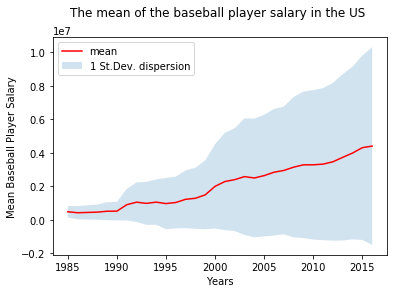

In [1]:
import numpy as np
import pandas as pd
import unicodecsv
import matplotlib.pyplot as plt

dir = "./baseballdatabank-2017.1/core/"

teams_record = pd.read_csv(dir+"Teams.csv")
teams_on_teams = teams_record.groupby("teamID")
print "On Teams.csv, there are record entries of {} teams".format(len(teams_on_teams))
years_on_teams = teams_record.groupby("yearID")
print "from year {} to year {}\n\n".format(min(years_on_teams.groups.keys()),max(years_on_teams.groups.keys()))

salaries = pd.read_csv(dir+"Salaries.csv")
print "On Salaries.csv, there are totally {} saraly record entries".format(str(len(salaries)))

players_on_salary = salaries.groupby('playerID')
print "from {} different players,".format(str(len(players_on_salary)))

teams_on_salary = salaries.groupby('teamID')
print "and {} teams.".format(str(len(teams_on_salary)))

years_on_salary = salaries.groupby('yearID')

print "from year {} to year {}\n\n".format(min(years_on_salary.groups.keys()),max(years_on_salary.groups.keys()))

salaries_stats = years_on_salary.agg([np.mean,np.std])['salary']

plt.plot(salaries_stats['mean'],color='red',label = 'mean')
plt.fill_between(salaries_stats.index,
                 salaries_stats['mean']+salaries_stats['std'],
                 salaries_stats['mean']-salaries_stats['std'],
                 alpha = 0.2,
                 label='1 St.Dev. dispersion')

plt.title("The mean of the baseball player salary in the US \n")
plt.xlabel("Years")
plt.ylabel("Mean Baseball Player Salary")
plt.legend(loc='upper left')
plt.show()


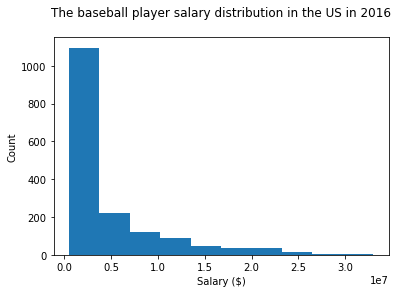

In [2]:

plt.hist(salaries.drop(salaries[salaries.yearID < 2015].index)['salary'].values)
plt.title("The baseball player salary distribution in the US in 2016\n")
plt.xlabel("Salary ($)")
plt.ylabel("Count")
plt.show()

In the Lehman baseball database, on the file Teams.csv, there records 149 teams from 1871 to 2016. On salaries.csv, there are totally 26428 saraly record entries from 1985-2016, from 5155 different players, and 46 teams.

The mean salary as well as the standard deviation increases rapidlly over years on the recent decades.

The second plot shows that salary distribution of baseball player in the US in 2016. The majority players have an annual salary less than 5,000,000 dollars(still a lot!). The higher salary it becomes, the fewer players there are.  

I am curiously to see whether a team's investment on players' salary relates to its ranking, and I focus on the data after 2009. 


### Salary and team's performance in 2010~2016

In [3]:
recent_salaries = salaries.drop(salaries[salaries.yearID < 2010].index)
recent_salaries_by_teams = recent_salaries.groupby('teamID')
recent_team_invest = recent_salaries_by_teams['salary'].sum().to_frame().reset_index()


I transform a team's ranking in the recent 7 years to a new metric "performance" by the following code. 

In [4]:

teams_record.drop(teams_record[teams_record['yearID']<2010].index,inplace = True)
max_position =  teams_record['Rank'].max()
teams_record['Performance'] = (max_position +1 - teams_record['Rank'])/((max_position+1)*(2016-2010))
teams_record_byteamID = teams_record.groupby('teamID')
recent_team_ranking =  teams_record_byteamID['Performance'].sum().to_frame().reset_index()


In [5]:
print "on Teams.csv, from 2010 to 2016, there records {} teams".format(len(teams_record_byteamID))
print "on salaries.csv, from 2010 to 2016, there records {} teams".format(len(recent_salaries_by_teams))

on Teams.csv, from 2010 to 2016, there records 31 teams
on salaries.csv, from 2010 to 2016, there records 42 teams


From the above lines of code, we can see that on Teams.csv, from 2010 to 2016, there records 31 teams, While on salaries.csv, from 2010 to 2016, there records 42 teams. There are 11 teams missing on the teams_record. To see the data between salary investment and performance, I merge the data frame based on the key of teamID on recent_team_ranking from Teams.csv. I further use dataframe.isnull().sum() to check if there is any missing values. (The result shows no.) 

In [6]:
invest_ranking = recent_team_invest.merge(recent_team_ranking,how='right',on='teamID')

print invest_ranking.isnull().sum()

teamID         0
salary         0
Performance    0
dtype: int64


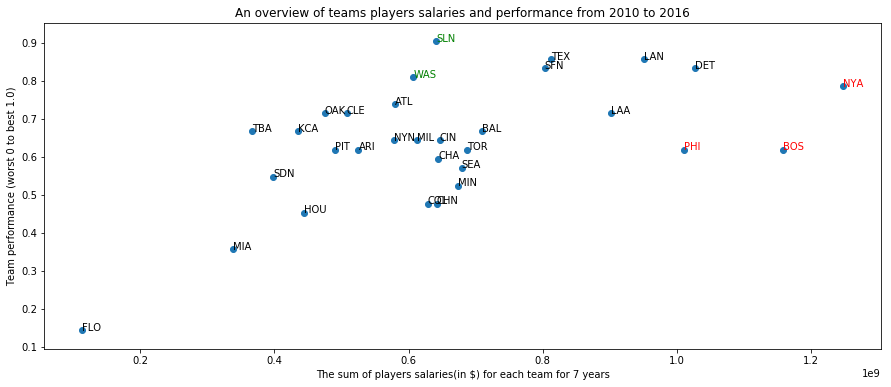

In [7]:
plt.figure(figsize=(15,6))
plt.title("An overview of teams players salaries and performance from 2010 to 2016")
plt.scatter(invest_ranking['salary'],invest_ranking['Performance'])
plt.xlabel('The sum of players salaries(in $) for each team for 7 years' )
plt.ylabel('Team performance (worst 0 to best 1.0)')

for i, name in enumerate(invest_ranking['teamID']):
    if name == 'SLN' or name == 'WAS':
        plt.annotate(name,(invest_ranking['salary'][i],invest_ranking['Performance'][i]),color='green')
    elif name == 'BOS' or name == 'NYA' or name=="PHI":
        plt.annotate(name,(invest_ranking['salary'][i],invest_ranking['Performance'][i]),color='red')
    else:
        plt.annotate(name,(invest_ranking['salary'][i],invest_ranking['Performance'][i]))

plt.show()

Basically, the total investment on players' salary is positive related to the performance. We also notice that team SLN spent around half of BOS and NYA, but it has the best ranking in the recent years. 

Actually I have never watched a single baseball match and I know little of it. After reading some related articals, I learn Bill Beane's formula of Base Percentage (OBP), and Slugging Percentage (SLG) to evaluate and recruite players. 

I would like to inverstage whether OBP or SLG relates to a player's salary and a team's performance. 



### Exploring how OBP and SLG indices relate to salary and performance

In [8]:

teams_record['OBP'] = (teams_record['H'] + teams_record['BB'] +teams_record['HBP'])/(teams_record['AB']+teams_record['BB']+teams_record['HBP']+teams_record['SF'])
teams_record['SLG'] = (teams_record['H'] +2*teams_record['2B']+3*teams_record['3B']+4*teams_record['HR'])/(teams_record['AB'])


team_record_byteamID = teams_record.groupby('teamID')

# building dataframe summary concisely presents the variables of performance,salary
#  and the OBP,SLG values of each team

OBP =  team_record_byteamID['OBP'].mean().to_frame().reset_index()
SLG =  team_record_byteamID['SLG'].mean().to_frame().reset_index()

summary = invest_ranking.merge(OBP, how = 'right', on = 'teamID').merge(SLG, how = 'right', on = 'teamID')

print summary.head()




  teamID      salary  Performance       OBP       SLG
0    ARI   525429395     0.619048  0.320609  0.496882
1    ATL   580016366     0.738095  0.318301  0.461594
2    BAL   708988159     0.666667  0.312999  0.506835
3    BOS  1157595515     0.619048  0.334489  0.526195
4    CHA   644507977     0.595238  0.314897  0.480130


#### Plotting OBP index and team salary / performance

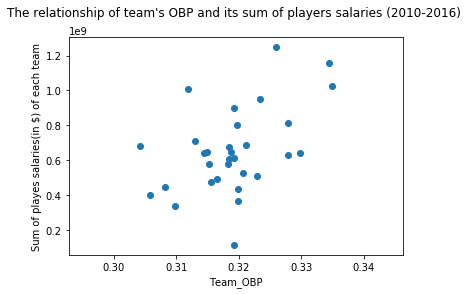

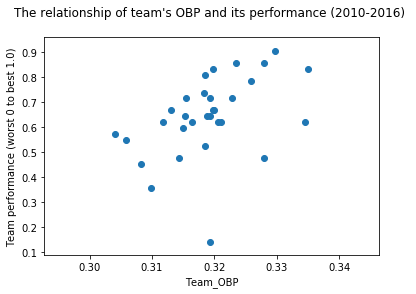

In [9]:
plt.scatter(summary['OBP'], summary['salary'])
plt.title("The relationship of team's OBP and its sum of players salaries (2010-2016) \n")
plt.xlabel('Team_OBP')
plt.ylabel('Sum of playes salaries(in $) of each team')
plt.show()

plt.scatter(summary['OBP'],summary['Performance'] )
plt.title("The relationship of team's OBP and its performance (2010-2016) \n")
plt.xlabel('Team_OBP')
plt.ylabel('Team performance (worst 0 to best 1.0)')
plt.show()

By plotting a team's OBP with its total salary and performance, we can see that a team with higher mean OBP value are likely to pay more on the players salary, and also tend to perform better. 

To see the correlation between OBP value and salary (and performance), we use T-test to perform hypothesis testing. The following piece of code use Python's statsmodels libray to build to regression model. 


#### Quantitative analysis on OBP index and team salary / performance

In [10]:
import statsmodels.formula.api as sm

# analysis the corelation between salary and OBP
OBP_salary_model = sm.ols("salary~OBP",summary)
OBP_salary = OBP_salary_model.fit()
print OBP_salary.pvalues

OBP_perform_model = sm.ols("Performance~OBP",summary)
OBP_perform = OBP_perform_model.fit()
print OBP_perform.pvalues


Intercept    0.016500
OBP          0.006675
dtype: float64
Intercept    0.040487
OBP          0.011338
dtype: float64


We choose the common alpha level as 0.05, with p-value(salary~OBP) = 0.006 < 0.05, we can reject the null hypotheses that OBP value doesn't relate to the salaries. Similar, with p-value(performance~OBP) = 0.011 < 0.05, we can reject the null hypotheses that OBP value doesn't affect the team's performance. On another word, players with high OBP are likely to play well, and might also valued high on the market. 

However, correlation doesn't mean causation, further study about how high OBP players bahave in team play would be interesting to validate the hypotheses. 


#### Plotting SLG index and team salary / performance

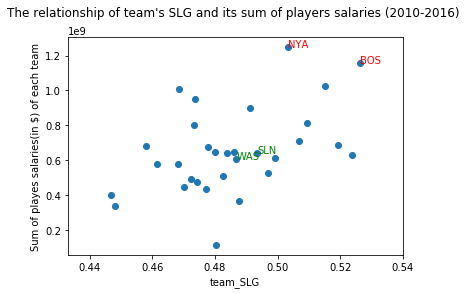

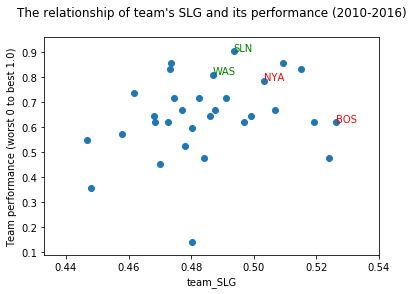

In [11]:
plt.scatter(summary['SLG'],summary['salary'] )
plt.title("The relationship of team's SLG and its sum of players salaries (2010-2016) \n")
plt.xlabel('team_SLG')
plt.ylabel('Sum of playes salaries(in $) of each team')
for i, name in enumerate(invest_ranking['teamID']):
    if name == 'SLN' or name == 'WAS' :
        plt.annotate(name,(team_record_byteamID['SLG'].mean().values[i],invest_ranking['salary'][i]),color='green')
    if name == 'BOS' or name == 'NYA' :
        plt.annotate(name,(team_record_byteamID['SLG'].mean().values[i],invest_ranking['salary'][i]),color='red')

plt.show()

plt.scatter(summary['SLG'],summary['Performance'] )
plt.title("The relationship of team's SLG and its performance (2010-2016)\n ")
plt.xlabel('team_SLG')
plt.ylabel('Team performance (worst 0 to best 1.0)')
for i, name in enumerate(invest_ranking['teamID']):
    if name == 'SLN' or name == 'WAS':
        plt.annotate(name,(team_record_byteamID['SLG'].mean().values[i],team_record_byteamID['Performance'].sum().values[i]),color='green')
    if name == 'BOS' or name == 'NYA' :
        plt.annotate(name,(team_record_byteamID['SLG'].mean().values[i],team_record_byteamID['Performance'].sum().values[i]),color='red')

plt.show()

#### Quantitative analysis on OBP index and team salary / performance

In [12]:

SLG_salary_model = sm.ols("salary~SLG",summary)
SLG_salary = SLG_salary_model.fit()
print SLG_salary.pvalues

SLG_perform_model = sm.ols("Performance~SLG",summary)
SLG_perform = SLG_perform_model.fit()
print SLG_perform.pvalues

Intercept    0.040935
SLG          0.008349
dtype: float64
Intercept    0.699231
SLG          0.190424
dtype: float64


#### Conclusion

Similary, we do the same analysis between SLG and team salary (and performance). with p-value(salary~SLG) = 0.008 < 0.05, we can reject the null hypotheses that SLG value doesn't relate to the salaries, on another word, player with high SLG value seems to be also valued high on the markets. 

However, with p-value(performance~SLG) = 0.19 >0.05, we can NOT reject the null hyphothese that SLG value doesn't affect the teams' performance. The results suggest that, recuiting players based on the SLG formula might not be the right strategy.

There is also limitation on this analysis. We focus on the data from a short(recent) time (2010-2016); mentioned in above, the data 11 teams are missing on the Salaries.csv file. However, we still can get some interesting information here. From the plotting, team NYA and BOS seem to invest a lot on players and their SLG values are reasonable high, but the gaining is not abvious; while team SLN and WAS has close SLG values, and close pay on the players. In order to discover good players who are undervalued by the current market, I think further investment about the metric of SLN and WAS's player is worth. In the consideration of team play, it would be interesting to further invesigate some factors such as distribution of different levels of players, the colleage which the players are from, the continueing years that players serve the same team, whether the highest SLG players cooperate well the other players, and so on.  





